# PRÁCTICA 3


***Competición en Kaggle***

---


**José María Sanchez Guerrero**


---




In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

# Utiles para seleccion de modelos
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve

# Pipelines
from sklearn.pipeline import make_pipeline

# Grid Search
from sklearn.model_selection import GridSearchCV

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
def plot_learning_curve(model, title, X, y, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 10)):

    # Establecer escala de figura y títulos
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Calcula la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=None, train_sizes=train_sizes)

    # Calcula la media de aciertos y desviación típica
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Genera las áreas de influencia de las dos rectas
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Genera las rectas de para el training y el test
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    # Imprime la curva
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# **Lectura de datos:**

In [3]:
# Lectura de datos con pandas
df = pd.read_csv("train.csv")

# Mostramos los primeros datos y vemos sus características
df.head()

,id,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento,Precio_cat
0,1.0,Maruti Swift Dzire ZDI,G,2012.0,83000.0,Diesel,Manual,First,23.4 kmpl,1248 CC,74 bhp,5.0,NaN,3
1,2.0,Maruti Wagon R LXI Optional,I,2016.0,4800.0,Petrol,Manual,First,20.51 kmpl,998 CC,67.04 bhp,5.0,NaN,3
2,3.0,Mahindra KUV 100 mFALCON D75 K8,F,2016.0,26000.0,Diesel,Manual,First,25.32 kmpl,1198 CC,77 bhp,6.0,NaN,3
3,4.0,Hyundai i20 1.2 Magna,E,2013.0,56127.0,Petrol,Manual,First,18.5 kmpl,1197 CC,80 bhp,5.0,NaN,3
4,5.0,Honda Jazz 1.2 SV i VTEC,H,2017.0,41981.0,Petrol,Manual,First,18.7 kmpl,1199 CC,88.7 bhp,5.0,NaN,3


In [4]:
# Vemos la cantidad de datos nulos que hay
df.isnull().sum()

id                72
Nombre            72
Ciudad            72
Año               72
Kilometros        72
Combustible       72
Tipo_marchas      72
Mano              72
Consumo           73
Motor_CC         101
Potencia         175
Asientos         106
Descuento       4160
Precio_cat         0
dtype: int64

In [5]:
# Ordenamos por marca y eliminamos id para que sea mas facil lo demas
df = df.sort_values(['Potencia', 'Nombre'])

df['Descuento'] = df['Descuento'].fillna(0)
df['Nombre'] = df['Nombre'].ffill()

df = df.sort_values(['Nombre'])
df = df.ffill()
df = df.bfill()

df.head()

,id,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento,Precio_cat
677,678.0,Audi A3 35 TDI Attraction,D,2014.0,79271.0,Diesel,Automatic,First,20.38 kmpl,1968 CC,143 bhp,5.0,0.00,5
2104,2105.0,Audi A3 35 TDI Premium,B,2016.0,20003.0,Diesel,Automatic,First,20.38 kmpl,1968 CC,143 bhp,5.0,0.00,5
1965,1966.0,Audi A3 35 TDI Premium Plus,B,2016.0,39000.0,Diesel,Automatic,First,20.38 kmpl,1968 CC,143 bhp,5.0,42.89,5
3144,3145.0,Audi A3 35 TDI Technology,J,2017.0,22000.0,Diesel,Automatic,Second,20.38 kmpl,1968 CC,143 bhp,5.0,0.00,5
716,717.0,Audi A4 1.8 TFSI,B,2011.0,53000.0,Petrol,Automatic,First,12.3 kmpl,1781 CC,163.2 bhp,5.0,0.00,4


# **Preprocessing:**

In [6]:
data = df.copy()

data['Nombre'] = data['Nombre'].str.split(' ').str[0] + data['Nombre'].str.split(' ').str[1]
data['Consumo'] = data.Consumo.str.extract(r'(\d+[.\d]*)')
data['Motor_CC'] = data.Motor_CC.str.extract(r'(\d+[.\d]*)')
data['Potencia'] = data.Potencia.str.extract(r'(\d+[.\d]*)')
data = data.drop(['id'], axis=1)
data.head()
data.dtypes

Nombre           object
Ciudad           object
Año             float64
Kilometros      float64
Combustible      object
Tipo_marchas     object
Mano             object
Consumo          object
Motor_CC         object
Potencia         object
Asientos        float64
Descuento       float64
Precio_cat        int64
dtype: object

In [7]:
from sklearn.preprocessing import LabelEncoder

# Codificamos las columnas representadas con cadenas para que se muestren como enteros
le = LabelEncoder()
data["Nombre"] = le.fit_transform(data["Nombre"].astype(str))
data["Ciudad"] = le.fit_transform(data["Ciudad"].astype(str))
data["Combustible"] = le.fit_transform(data["Combustible"].astype(str))
data["Tipo_marchas"] = le.fit_transform(data["Tipo_marchas"].astype(str))
data["Mano"] = le.fit_transform(data["Mano"].astype(str))
x_train2 = data.copy()

data.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento,Precio_cat
677,0,2,2014.0,79271.0,1,0,0,20.38,1968,143,5.0,0.00,5
2104,0,0,2016.0,20003.0,1,0,0,20.38,1968,143,5.0,0.00,5
1965,0,0,2016.0,39000.0,1,0,0,20.38,1968,143,5.0,42.89,5
3144,0,8,2017.0,22000.0,1,0,2,20.38,1968,143,5.0,0.00,5
716,1,0,2011.0,53000.0,4,0,0,12.3,1781,163.2,5.0,0.00,4


In [8]:
data = np.array(data)
data[:5]

array([[0, 2, 2014.0, 79271.0, 1, 0, 0, '20.38', '1968', '143', 5.0, 0.0,
        5],
       [0, 0, 2016.0, 20003.0, 1, 0, 0, '20.38', '1968', '143', 5.0, 0.0,
        5],
       [0, 0, 2016.0, 39000.0, 1, 0, 0, '20.38', '1968', '143', 5.0,
        42.89, 5],
       [0, 8, 2017.0, 22000.0, 1, 0, 2, '20.38', '1968', '143', 5.0, 0.0,
        5],
       [1, 0, 2011.0, 53000.0, 4, 0, 0, '12.3', '1781', '163.2', 5.0,
        0.0, 4]], dtype=object)

# **División de los datos:**

In [9]:
# Importamos la herramienta y hacemos la división en entrenamiento y test
from sklearn.model_selection import train_test_split

# Division de los datos entre atributos y clases
x_train = data[:,:-1]
y_train = data[:,-1].astype('int')

print(x_train.shape)

(4819, 12)


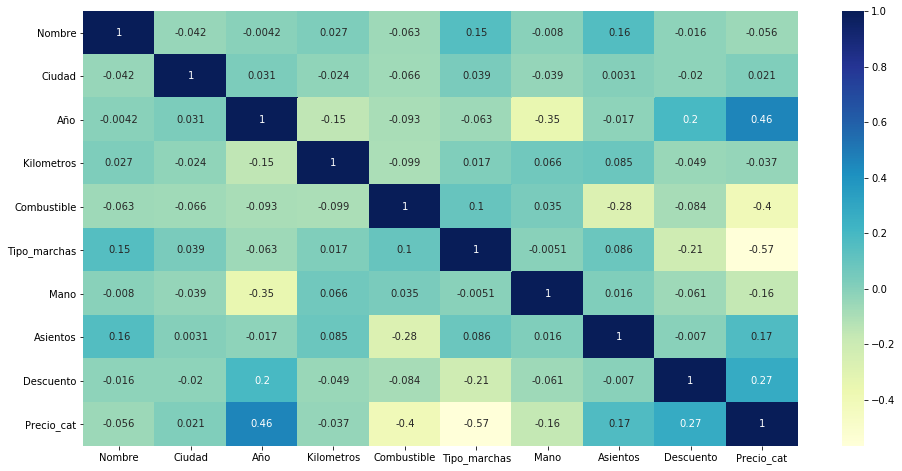

In [10]:
# Correlation matrix
cor = x_train2.corr()

# Figure size
plt.figure(figsize=(16,8))

# Heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

# **Configuración de los algoritmos:**

### Prueba rápida

              precision    recall  f1-score   support

           1       0.71      0.61      0.66       269
           2       0.45      0.41      0.43       602
           3       0.75      0.77      0.76      2211
           4       0.55      0.53      0.54       978
           5       0.70      0.75      0.72       759

    accuracy                           0.66      4819
   macro avg       0.63      0.61      0.62      4819
weighted avg       0.66      0.66      0.66      4819

SCORE:  0.6642456941274123


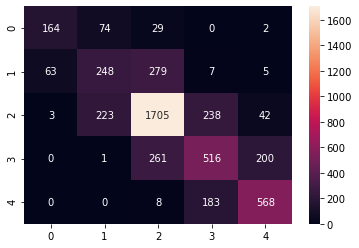

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
RndForestClf = RandomForestClassifier(n_estimators=100)

# Calculo de las predicciones mediante validacion cruzada (5-folds)
y_pred = cross_val_predict(RndForestClf, x_train, y_train, cv=5)

print(classification_report(y_train, y_pred))
print("SCORE: ", accuracy_score(y_train, y_pred))

# Matriz de confusion de los resultados
confusion_matrix = confusion_matrix(y_train, y_pred)

sns.heatmap(confusion_matrix, annot = True, fmt='g')

### RandomForest y MLP (probando parámetros)

In [12]:
# Creamos las listas de valores para los determinados modelos
c_list = [0.1, 1.0, 5.0]
n_estimators_list = [50, 100, 200]
hidden_layer_sizes_list = [(100,100)]

# Asignamos nombres a los modelos
model_names = ['RF n_estimators = 50',
               'RF n_estimators = 100', 'RF n_estimators = 200',
               'NN hidden_layer_sizes = 100-100']

# Crear 5-fold que conserva la proporcion
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [14]:
from sklearn.preprocessing import StandardScaler

# Crear lista de pipelines
pipelines = []

# Insertar nuevo pipeline
for n_estimators in n_estimators_list:
    pipelines.append(
        make_pipeline(
            RandomForestClassifier(n_estimators=n_estimators, max_depth=None, random_state=1)
        )
    )
rf_pipe = pipelines


# Crear lista de pipelines
pipelines = []

# Insertar nuevo pipeline
for hidden_layer_sizes in hidden_layer_sizes_list :
    pipelines.append(
        make_pipeline(
            StandardScaler(),
            MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, early_stopping=False, random_state=1)
        )
    )
nn_pipe = pipelines


models = rf_pipe + nn_pipe

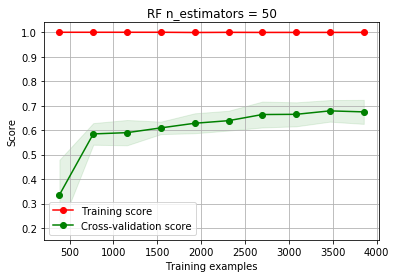

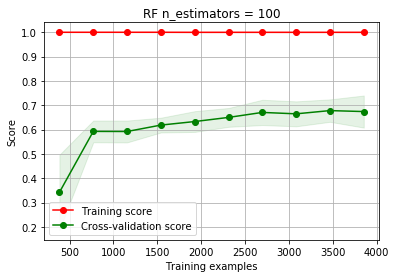

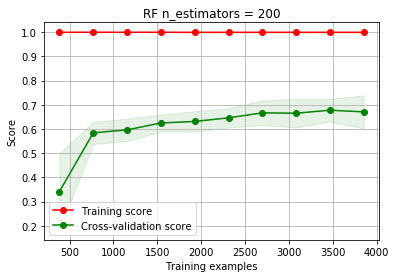

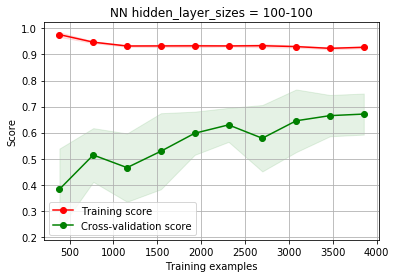

                                 Mean Accuracy  Standard Deviation
RF n_estimators = 50                  0.667965            0.057080
RF n_estimators = 100                 0.669206            0.071944
RF n_estimators = 200                 0.671908            0.067113
NN hidden_layer_sizes = 100-100       0.685602            0.054714


In [15]:
# Obtener valores medios, desviaciones y curvas de aprendizaje de los modelos
# Crear listas de medias y desviacions
means = []
deviations = []

# Para cada modelo, obtener los resultados de evaluar el modelo con todas las particiones
# Guardar los resultados en las listas correspondientes
for idx,model in enumerate(models):
    results = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=5)

    # Guardar valor medio de los errores
    # Se guarda el valor absoluto porque son valores negativos
    means.append(abs(results.mean()))

    # Guardar desviaciones
    deviations.append(np.std(results))

    # Imprime la curva de aprendizaje del modelo
    plot_learning_curve(model, model_names[idx], x_train, y_train, cv=5)

out_df = pd.DataFrame(index=model_names, columns=['Mean Accuracy', 'Standard Deviation'],
                          data=[[mean, dev] for mean, dev in zip(means, deviations)])
print(out_df)

In [16]:
modelo = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=1)

# Train the model
modelo.fit(x_train, y_train)

# Test on unseen data
labels = modelo.predict(x_test)

#sample.to_csv('sample.csv', index=False)